In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
def create_graph_data(df, node_list):
    # Create a mapping of node names to indices
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Convert edges to indices
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T  # Transpose to get the shape [2, num_edges]

    # Node features (converted to numpy array or tensor)
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)

    # Labels (0 for non-fraud, 1 for fraud)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)

    return node_features, edge_index, labels, node_map


In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels, node_map = create_graph_data(df, node_list)

In [7]:
# Plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

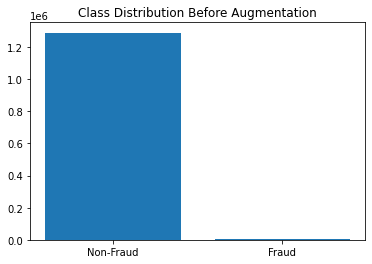

In [8]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation")

In [9]:
def build_adjacency_matrix(edge_index, num_nodes):
    """Build a sparse adjacency matrix from edge indices."""
    # Convert edge_index to long tensors
    row_indices = edge_index[0].long()  # Ensure indices are of type long
    col_indices = edge_index[1].long()

    # Create a sparse adjacency matrix
    adj = torch.sparse_coo_tensor(
        torch.stack([row_indices, col_indices]),  # Indices of non-zero elements
        torch.ones(row_indices.size(0)),  # Values (unweighted)
        (num_nodes, num_nodes)  # Shape of the matrix
    )

    return adj

In [10]:
def expand_adjacency_matrix(adj, new_nodes_count):
    """
    Expands the adjacency matrix to accommodate new nodes by adding rows and columns for the new nodes.
    Assumes no initial edges for the new nodes, i.e., they start with no connections.
    """
    num_existing_nodes = adj.shape[0]
    new_size = num_existing_nodes + new_nodes_count
    
    # Expand the adjacency matrix with zeros for new nodes (initially, no edges for new nodes)
    expanded_adj = torch.zeros(new_size, new_size)
    
    # Copy the old adjacency matrix to the top-left corner of the expanded one
    expanded_adj[:num_existing_nodes, :num_existing_nodes] = adj
    
    return expanded_adj

In [11]:
import torch

def normalize_adj(adj):
    # Check if adj is a sparse tensor
    if adj.is_sparse:
        # Convert sparse tensor to dense
        adj = adj.to_dense()
    
    # Calculate the degree of each node
    degree = adj.sum(dim=1)  # Shape: (num_nodes,)
    degree_inv_sqrt = degree.pow(-0.5)  # Shape: (num_nodes,)
    degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0  # Handle division by zero

    # Normalize the adjacency matrix
    degree_inv_sqrt = degree_inv_sqrt.view(-1, 1)  # Reshape to (num_nodes, 1)
    adj_normalized = adj.mul(degree_inv_sqrt).mul(degree_inv_sqrt.t())  # Shape: (num_nodes, num_nodes)

    return adj_normalized

In [12]:
# Implement GCN layer manually
class SimpleGCNLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleGCNLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, x, adj):
        x = torch.relu(self.fc(adj @ x))  # Graph convolution using dense adjacency matrix
        return x

In [13]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # Graph convolution: x' = ReLU(Adjacency_matrix * x * Weights)
        x = torch.matmul(adj, x)  # Multiply adjacency matrix by input feature matrix
        x = self.fc(x)  # Apply the linear transformation (weights)
        return torch.relu(x)  # Apply ReLU activation


In [14]:
class WGANGeneratorWithManualGCN(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_nodes, edge_index):
        super(WGANGeneratorWithManualGCN, self).__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.gcn1 = GCNLayer(hidden_size, hidden_size)  # GCN Layer 1
        self.gcn2 = GCNLayer(hidden_size, hidden_size)  # GCN Layer 2
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.adj = self.build_sparse_adjacency_matrix(edge_index, num_nodes)  # Build adjacency matrix once in the constructor
        self.num_nodes = num_nodes  # Total number of nodes in the graph

    def forward(self, z):
        # Pass through the first fully connected layer
        z = torch.relu(self.fc1(z))

        # Use the precomputed adjacency matrix
        adj = self.adj
        z = z[:self.num_nodes]  # Adjust size of z to match the number of nodes
        
        # Pass through GCN layers
        z = self.gcn1(z, adj)  # Graph convolution using the adjacency matrix
        z = self.gcn2(z, adj)
        
        # Final output layer
        return self.fc2(z)

    def build_sparse_adjacency_matrix(self, edge_index, num_nodes):
        # Ensure edge_index is a LongTensor
        if isinstance(edge_index, torch.Tensor):
            edge_index = edge_index.long()
        else:
            raise ValueError("edge_index should be a torch.Tensor")

        # Create the sparse adjacency matrix
        values = torch.ones(edge_index.shape[1], dtype=torch.float)  # Use ones for unweighted edges
        adj_sparse = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
        return adj_sparse

    def normalize_sparse_adj(self, adj):
        # Compute degree matrix
        degree = torch.sparse.sum(adj, dim=1).to_dense()
        degree_inv_sqrt = torch.pow(degree, -0.5)
        degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0  # Avoid division by zero

        # Apply normalization: D^(-1/2) * A * D^(-1/2)
        adj_normalized = adj.coalesce()  # Ensures indices are sorted, necessary for sparse tensor operations
        adj_normalized = adj_normalized * degree_inv_sqrt.unsqueeze(0) * degree_inv_sqrt.unsqueeze(1)
        return adj_normalized

In [15]:
class WGANDiscriminator(nn.Module):
    def __init__(self, input_size=4, hidden_size=64):
        super(WGANDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer expects 4 features
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Hidden layer
        self.fc3 = nn.Linear(hidden_size, 1)  # Output layer produces a single output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # First fully connected layer
        x = torch.relu(self.fc2(x))  # Second fully connected layer
        x = self.fc3(x)  # Output
        return x

In [16]:
latent_size = 100
hidden_size = 64
input_size = 1676
output_size = 1676
num_nodes = 1676

In [17]:
def dense_to_edge_index(adj):
    # Get the indices of non-zero elements (i.e., the edges)
    edge_index = adj.nonzero(as_tuple=False).t()
    return edge_index

In [18]:
adj_dense = torch.rand(num_nodes, num_nodes)  # Random dense adjacency matrix for demonstration
adj_dense[adj_dense < 0.5] = 0  # Making it sparse by zeroing some elements
adj_dense = adj_dense > 0  # Convert to binary (0s and 1s)

# Convert to edge index
edge_index = dense_to_edge_index(adj_dense)

In [19]:
# Build and normalize adjacency matrix
adj = build_adjacency_matrix(edge_index, num_nodes)
adj = normalize_adj(adj)

In [20]:
adj = dense_to_edge_index(adj)

In [21]:
# Assuming adj is your adjacency matrix tensor
print(f"Shape of adj: {adj.shape}")

Shape of adj: torch.Size([2, 1404899])


In [22]:
generator = WGANGeneratorWithManualGCN(latent_size, hidden_size, output_size, num_nodes, edge_index)
discriminator = WGANDiscriminator(input_size, hidden_size)

In [23]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)

In [24]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [25]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(node_features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([2.3957e-03, 6.2278e+00, 4.4526e+02, 2.6677e+01]), Initial Variance: tensor([3.0670e-05, 1.5315e+01, 6.6874e+04, 2.0538e+02]), Initial Std Dev: tensor([5.5381e-03, 3.9134e+00, 2.5860e+02, 1.4331e+01])


In [26]:
# Training with early stopping
num_epochs = 1
target_minority_class = torch.sum(labels == 0)
real_data = node_features[labels == 1]

In [27]:
# Early stopping parameters
best_loss_d = float('inf')
patience = 1
trigger_times = 0

In [28]:
# Expand the adjacency matrix to accommodate the new fake nodes
adj = expand_adjacency_matrix(adj, fake_data.size(0))

# Concatenate the new fake data to node_features
labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))  # Add labels for fake nodes
node_features = torch.cat((node_features, fake_data))

# Debugging prints to check the updated adjacency matrix and node features
print(f'Adjacency Matrix Shape after expansion: {adj.shape}')
print(f'Node Features Shape after concatenation: {node_features.shape}')

NameError: name 'fake_data' is not defined

In [ ]:
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Update the discriminator
    for _ in range(1):
        z = torch.randn(real_data.size(0), latent_size, dtype=torch.float)  # Ensure dtype is float
        fake_data = generator(z)

        optimizer_d.zero_grad()
        print(f'Real Data Shape: {real_data.shape}')

        d_real = discriminator(real_data)
        print("Here")
        d_fake = discriminator(fake_data.detach())
        loss_d = -torch.mean(d_real) + torch.mean(d_fake)
        loss_d.backward()
        optimizer_d.step()

        # Clip weights
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    # Update the generator
    optimizer_g.zero_grad()
    fake_data = generator(torch.randn(real_data.size(0), latent_size, dtype=torch.float))  # Ensure dtype is float
    loss_g = -torch.mean(discriminator(fake_data))
    loss_g.backward()
    optimizer_g.step()

    # Concatenate the new fake data
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))  # Ensure labels are torch.long
    node_features = torch.cat((node_features, fake_data))

    # Debugging prints to check the shape of adjacency matrix and node features
    print(f'Adjacency Matrix Shape after expansion: {adj.shape}')
    print(f'Node Features Shape after concatenation: {node_features.shape}')

    # Check if adj and node_features have the same number of nodes
    if adj.shape[0] != node_features.shape[0]:
        print("Here")
        raise RuntimeError(f'Adjacency matrix shape {adj.shape} does not match node features shape {node_features.shape}')

    # Early stopping check
    if loss_d.item() < best_loss_d:
        best_loss_d = loss_d.item()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping triggered")
        break

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

In [ ]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))
y_generated = torch.ones(num_generated_samples, dtype=torch.long)

In [ ]:
# Add R-squared calculation function
def r_squared(real_data, generated_data):
    # Mean of real data
    real_mean = torch.mean(real_data, dim=0)
    
    # Total sum of squares (variance of the real data)
    ss_tot = torch.sum((real_data - real_mean) ** 2)
    
    # Residual sum of squares (difference between real and generated data)
    ss_res = torch.sum((real_data - generated_data) ** 2)
    
    # R-squared calculation
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
# After augmentation, compute R-squared
r2_score = r_squared(real_data, generated_data)

In [ ]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

In [ ]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation")

In [ ]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")
print(f"Final R-squared: {r2_score.item()}")